Test compositional lotka volterra algorithm on miaSim time series.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import pickle as pkl
import torch
from scipy.io import loadmat

# from scipy.special import logsumexp
# from scipy.stats import pearsonr
# from scipy.stats import norm

from clv.compositional_lotka_volterra import *

from clv.generalized_lotka_volterra import ridge_regression_glv

In [6]:
max_samples = 150
n_samples = 500
n_otu = 4

# path of data file
filename = f"miaSim_GLV_{n_otu}species_oscillating_zero.csv"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/data/"

In [7]:
# function to import the datafile and put it into the right format
def create_data():
    data = np.genfromtxt(f'{filepath}{filename}', delimiter=",")
    usol = data[1:, :]  # removes header
    if "max_samples" in globals():
        ts = usol[0:max_samples, 0]
        data_y = usol[0:max_samples, 1:]
    else:
        ts = usol[:, 0]
        data_y = usol[:, 1:]
    # set dimensions of the dataset
    global n_samples, n_taxa
    n_samples, n_taxa = data_y.shape
    print("The coodinates have shape {}".format(ts.shape))
    print("The data has shape {}".format(data_y.shape)) 
    return [ts], [data_y]

In [8]:
T, Y = create_data()

The coodinates have shape (150,)
The data has shape (150, 4)


In [9]:
T[0].shape

(150,)

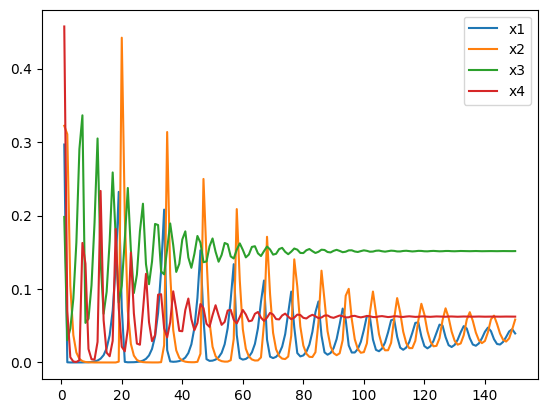

In [10]:
fig, ax = plt.subplots()
for i in np.arange(n_taxa):
    ax.plot(T[0], Y[0][:,i], label = f"x{i+1}")
ax.legend()

In [11]:
Y = adjust_concentrations(Y)
print(Y)

[array([[2.96633792e-01, 3.22162959e-01, 1.98089902e-01, 4.57300968e-01],
       [2.59109573e-04, 3.10705807e-01, 3.03721310e-02, 6.99952834e-02],
       [3.02578194e-05, 1.04329161e-01, 4.59757423e-02, 7.05563659e-03],
       [2.22582348e-05, 3.71806261e-02, 8.68770984e-02, 1.26338874e-03],
       [3.05343805e-05, 1.35273913e-02, 1.63263981e-01, 7.12870367e-04],
       [5.23312847e-05, 4.96064963e-03, 2.90370661e-01, 3.03856620e-03],
       [9.72442160e-05, 1.82614719e-03, 3.36390127e-01, 1.62669588e-01],
       [1.86139466e-04, 6.74187531e-04, 5.38821205e-02, 1.34483947e-01],
       [3.60197951e-04, 2.49956129e-04, 5.94811508e-02, 1.83365996e-02],
       [6.99840529e-04, 9.34055574e-05, 1.05087665e-01, 4.45764362e-03],
       [1.36142036e-03, 3.54147870e-05, 1.89909212e-01, 3.93329068e-03],
       [2.64862079e-03, 1.38105004e-05, 3.04880701e-01, 2.80348972e-02],
       [5.14846804e-03, 5.68761546e-06, 1.38347363e-01, 2.33496314e-01],
       [9.99092570e-03, 2.60516982e-06, 6.62610160

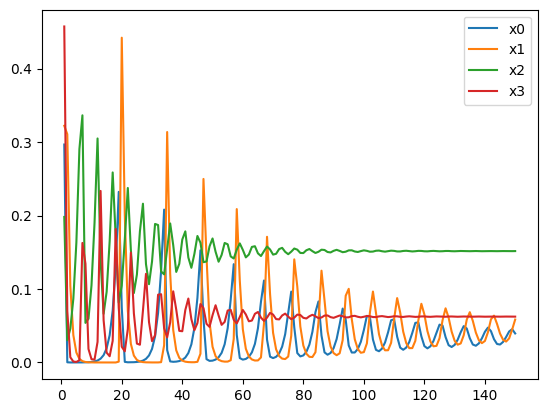

In [12]:
fig, ax = plt.subplots()
for i in np.arange(n_otu):
    ax.plot(T[0], Y[0][:,i], label = f"x{i}")
ax.legend()

In [13]:
P = []
Y_pc = []
log_Y = []
for y in Y:
    mass = y.sum(axis=1)
    p = y / y.sum(axis=1,keepdims=True)
    p = (p + 1e-5) / (p + 1e-5).sum(axis=1,keepdims=True)
    P.append(p)
    Y_pc.append((mass.T*p.T).T)
    log_Y.append(np.log(mass.T*p.T).T)

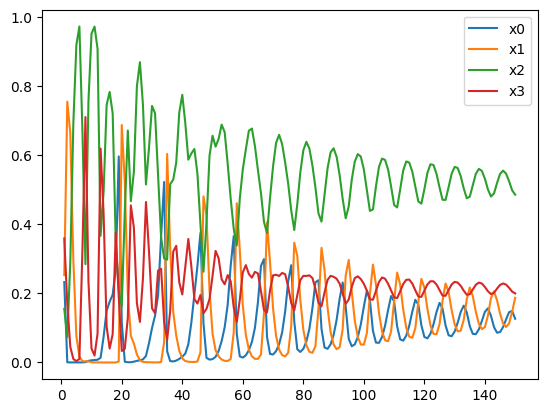

In [14]:
# plot P
fig, ax = plt.subplots()
for i in np.arange(n_otu):
    ax.plot(T[0], P[0][:,i], label = f"x{i}")
ax.legend()

### ALR transformation and denominator search

In [15]:
# denom check (from choose_denom(P))
np.seterr(divide="ignore", invalid="ignore")
vars = []
log_change = None
for p in P:
    s = p.sum(axis=1,keepdims=True)
    s[s==0] = 1
    deltas = np.log( (p/s)[1:] ) - np.log( (p/s)[:-1] )
    if log_change is None:
        log_change = deltas
    else:
        log_change = np.vstack((log_change, deltas))
np.seterr(divide="warn", invalid="warn")
# pick taxon with smallest change in log proportion
min_var = np.inf
ntaxa = log_change.shape[1]
for i in range(ntaxa):
    if not np.all(np.isfinite(log_change[:,i])):
        continue
    var = np.var(log_change[:,i])
    vars.append(var)

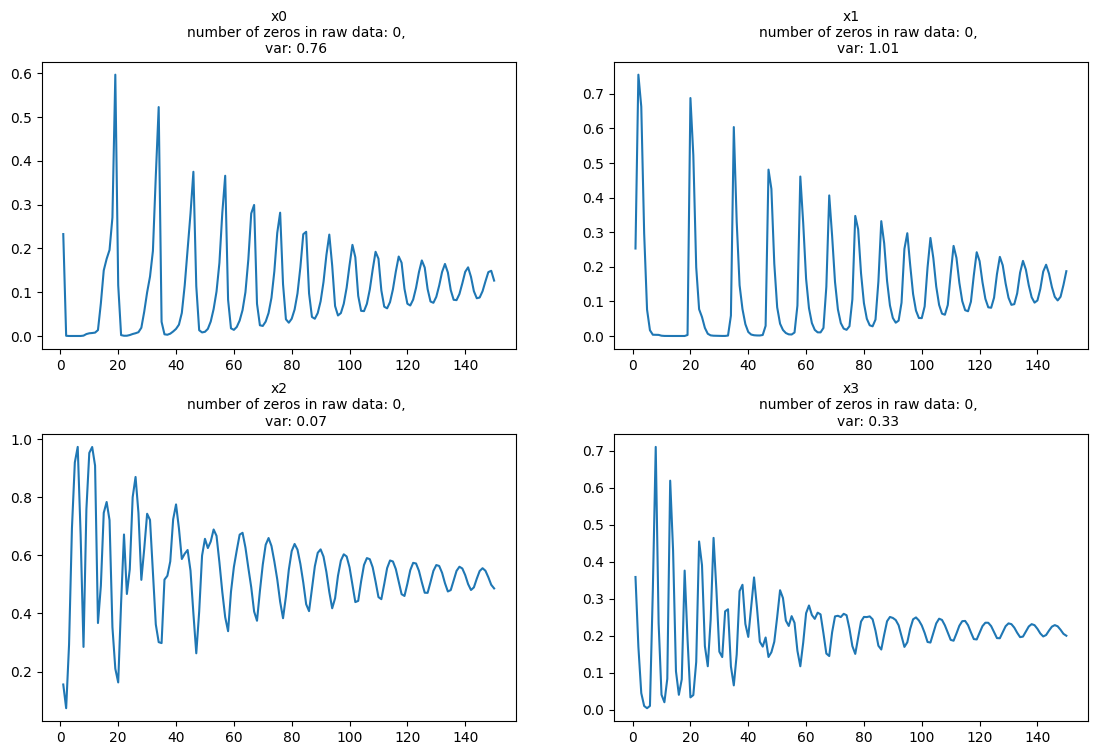

In [16]:
n_row = 2
n_col = 2
fig, axs = plt.subplots(n_row, n_col)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.tight_layout(pad=4.0)
for i in np.arange(n_taxa):
    # plot each taxon timeline separately
    axs[math.floor(i/n_col), (i%n_col)].plot(T[0], P[0][:,i])
    axs[math.floor(i/n_col), (i%n_col)].set_title(f"""x{i}
        number of zeros in raw data: {sum(Y[0][:,i] == 0)},
        var: {round(vars[i],2)}""")
    axs[math.floor(i/n_col), (i%n_col)].title.set_size(10)

In [17]:
denom = choose_denom(P)
print(denom)

ALR = construct_alr(P, denom)

U = [ np.zeros((x.shape[0], 1)) for x in ALR ]

2


In [18]:
alpha, r_A, r_g, r_B = estimate_elastic_net_regularizers_cv(ALR[0], P[0], U = U[0], T=T[0], denom=denom, folds=10, no_effects=True, verbose=False)

	r (0.1, 0.1, 0.1, 0) sqr error 0


In [19]:
clv = CompositionalLotkaVolterra(P, T, denom=denom, pseudo_count=1e-5)

In [20]:
clv.alpha = alpha
clv.r_A = r_A
clv.r_g = r_g
clv.r_B = r_B

In [19]:
# clv.alpha = 1
# clv.r_A = 0.5
# clv.r_g = 0.5
# clv.r_B = 0

In [21]:
clv.train()

In [22]:
clv.A

array([[-1.96088719, -3.17741854,  2.01880739,  2.15614799],
       [ 7.35389155, -3.20071407, -2.36516618, -0.72193172],
       [ 0.15993948, -0.41365826,  1.96303748, -2.26328305]])

### Generalized Lotka Volterra

In [23]:
def compute_relative_parameters(A_abs, g_abs, B_abs, denom):
    numer = np.array([i for i in range(A_abs.shape[0]) if i != denom])
    A_rel = A_abs[numer,:] - A_abs[denom,:]
    B_rel = B_abs[numer,:] - B_abs[denom,:]
    g_rel = g_abs[numer] - g_abs[denom]

    return A_rel, g_rel, B_rel

In [24]:
A_glv, g_glv, B_glv = ridge_regression_glv(log_Y, U, T, clv.r_A, clv.r_g, clv.r_B)

A_rel, g_rel, B_rel = compute_relative_parameters(A_glv, g_glv, B_glv, clv.denom) # to compare with clv

In [25]:
A_glv, g_glv, B_glv

(array([[-7.04649913, -9.84022856,  0.19315657, -2.28868833],
        [15.99020401, -4.60938553, -1.0844602 , -2.22064239],
        [-0.24496636,  0.11036695, -3.20032149, -3.77197156],
        [-0.35041536, -0.3080687 ,  9.28476426, -5.93810857]]),
 array([ 0.78987072, -0.05559423,  0.72771442, -1.01241283]),
 array([[0.],
        [0.],
        [0.],
        [0.]]))